In [1]:
import xtrack as xt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xpart as xp
import xobjects as xo
import yaml

In [2]:
# Now we want to start tracking particles!
# First of all let's load the collider and build the trackers
collider = xt.Multiline.from_json('../data/collider_thin.json')
collider.build_trackers()

Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [3]:
# Then we want to set the optics from a config file
# We will use the optics from the HL-LHC config
with open('../data/config.yaml', "r") as fid:
        config = yaml.safe_load(fid)
    
def set_orbit_from_config(collider, config):
    print('Setting optics as from config')
    for ii in ['on_x1', 'on_sep1', 'on_x2', 'on_sep2', 'on_x5',
               'on_sep5', 'on_x8h', 'on_x8v', 'on_sep8h', 'on_sep8v',
               'on_a1', 'on_o1', 'on_a2', 'on_o2', 'on_a5', 'on_o5', 'on_a8', 
               'on_o8', 'on_disp', 'on_crab1', 'on_crab5', 'on_alice_normalized', 
               'on_lhcb_normalized', 'on_sol_atlas', 'on_sol_cms', 'on_sol_alice', 
               'vrf400', 'lagrf400.b1', 'lagrf400.b2']:
        collider.vars[ii] = config['config_collider']['config_knobs_and_tuning']['knob_settings'][ii]

set_orbit_from_config(collider, config)

twiss_b1 = collider['lhcb1'].twiss()

Setting optics as from config


In [4]:
# First of all we define a context
ctx = xo.ContextCpu()
# Then we can define a single particle 
my_particle = xp.Particles(
                    mass0=xp.PROTON_MASS_EV, q0=1, energy0=7000e9, x = 1e-6)
# Let's look at it
my_particle.show()
# We can also access the particle attributes directly
# IMPORTANT: it is better to use the context to access the attributes 
# to avoid conflicts when using GPU contexts
print(f'The particle energy is {ctx.nparray_from_context_array(my_particle.energy0)} eV')
print(f'The particle x position is {ctx.nparray_from_context_array(my_particle.x)} m')

PARTICLES:


Property                           Value
-------------------------------------------------------
start_tracking_at_element             -1
q0                                   1.0
mass0                       938272088.1604904
s                                    0.0
zeta                                 0.0
chi                                  1.0
charge_ratio                         1.0
weight                               1.0
particle_id                            0
at_element                             0
at_turn                                0
state                                  1
parent_particle_id                     0
_rng_s1                                0
_rng_s2                                0
_rng_s3                                0
_rng_s4                                0
x                                  1e-06
y                                    0.0
px                                   0.0
py                                   0.0
delta                   

In [5]:
# Now we want to track the particle, we can do it with the tracker method
# IMPORTANT: each element of the collider can track particles separately!
# For example let's take a crab cavity and track the particle through it
# We can access the crab cavity with the following command
my_crab = collider["lhcb1"].element_dict['acfgah.4bl1.b1']
print(my_crab)

RFMultipole(order=0, inv_factorial_order=0.0, voltage=0.0, frequency=400789602.58620286, lag=0.0, knl=[4.8984021e-07], ksl=[0.], pn=[90.], ps=[0.])


In [6]:
# And we can track the particle with the following command
my_particle = xp.Particles(
                    mass0=xp.PROTON_MASS_EV, q0=1, energy0=7000e9, zeta = 0.075)
print('---------Particle before tracking------')
print(f'The particle px is {ctx.nparray_from_context_array(my_particle.px)}')
my_crab.track(my_particle)
print('---------Particle after tracking------')
print(f'The particle px is {ctx.nparray_from_context_array(my_particle.px)}')
# The particle px has changed! This is because the particle is at zeta!=0
# What if we want to track the particle at zeta=0?
# We can do it with the following command
my_particle = xp.Particles(
                    mass0=xp.PROTON_MASS_EV, q0=1, energy0=7000e9, zeta = 0)    
my_crab.track(my_particle)
print('---------Particle after tracking at zeta=0------')
print(f'The particle px is {ctx.nparray_from_context_array(my_particle.px)}')
# px changed but it's practically zero

---------Particle before tracking------
The particle px is [0.]
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
---------Particle after tracking------
The particle px is [-2.88584684e-07]
---------Particle after tracking at zeta=0------
The particle px is [-2.99940622e-23]


In [7]:
#Now for something more complicated we can track the particle through the whole line
#We can do it with the following command
my_particle = xp.Particles(
                    mass0=xp.PROTON_MASS_EV, q0=1, energy0=7000e9)
collider['lhcb1'].track(my_particle)
print('---------Particle after tracking through the whole line------')
my_particle.show()

---------Particle after tracking through the whole line------
PARTICLES:


Property                           Value
-------------------------------------------------------
start_tracking_at_element             -1
q0                                   1.0
mass0                       938272088.1604904
s                                    0.0
zeta                        2.214466818385557e-05
chi                                  1.0
charge_ratio                         1.0
weight                               1.0
particle_id                            0
at_element                             0
at_turn                                1
state                                  1
parent_particle_id                     0
_rng_s1                                0
_rng_s2                                0
_rng_s3                                0
_rng_s4                                0
x                           -9.618484005947436e-07
y                           -1.1988376186201738e-07
px            

In [8]:
# Now for a more realistic example we want to track a gaussian bunch of particles
# Matched to the RF bucket
N_particles = 10000
bunch_intensity = 2.2e11
normal_emitt_x = 2.5e-6 #m*rad
normal_emitt_y = 2.5e-6 #m*rad
sigma_z = 7.5e-2
particle_ref = xp.Particles(
                    mass0=xp.PROTON_MASS_EV, q0=1, energy0=7000e9)
gaussian_bunch = xp.generate_matched_gaussian_bunch(
        num_particles = N_particles, total_intensity_particles = bunch_intensity,
        nemitt_x = normal_emitt_x, nemitt_y=normal_emitt_y, sigma_z = sigma_z,
        particle_ref = particle_ref,
        line = collider['lhcb1'])

*** Maximum RMS bunch length 0.11789515101464539m.
... distance to target bunch length: -7.5000e-02
... distance to target bunch length: 3.9638e-02
... distance to target bunch length: 3.4969e-02
... distance to target bunch length: 8.3249e-03
... distance to target bunch length: -1.1693e-02
... distance to target bunch length: 8.3353e-04
... distance to target bunch length: -2.3602e-05
... distance to target bunch length: 1.8476e-07
... distance to target bunch length: -1.8173e-07
--> Bunch length: 0.07499981826886956
--> Emittance: 2.127387654536436


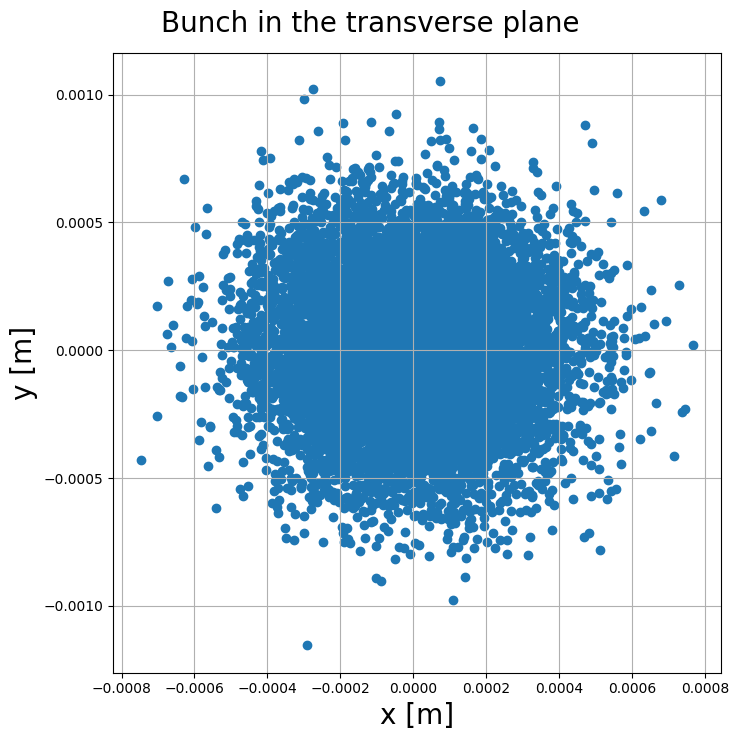

In [9]:
# We can plot the bunch in the transverse plane
starting_x = ctx.nparray_from_context_array(gaussian_bunch.x).copy()
starting_y = ctx.nparray_from_context_array(gaussian_bunch.y).copy()
starting_zeta = ctx.nparray_from_context_array(gaussian_bunch.zeta).copy()
fig, ax = plt.subplots(1,1)
fig.set_size_inches(7.5, 7.5)
fontsize = 20
fig.suptitle('Bunch in the transverse plane', fontsize = fontsize)
ax.scatter(starting_x, starting_y)
ax.set_xlabel('x [m]', fontsize = fontsize)
ax.set_ylabel('y [m]', fontsize = fontsize)
ax.grid()
plt.tight_layout()

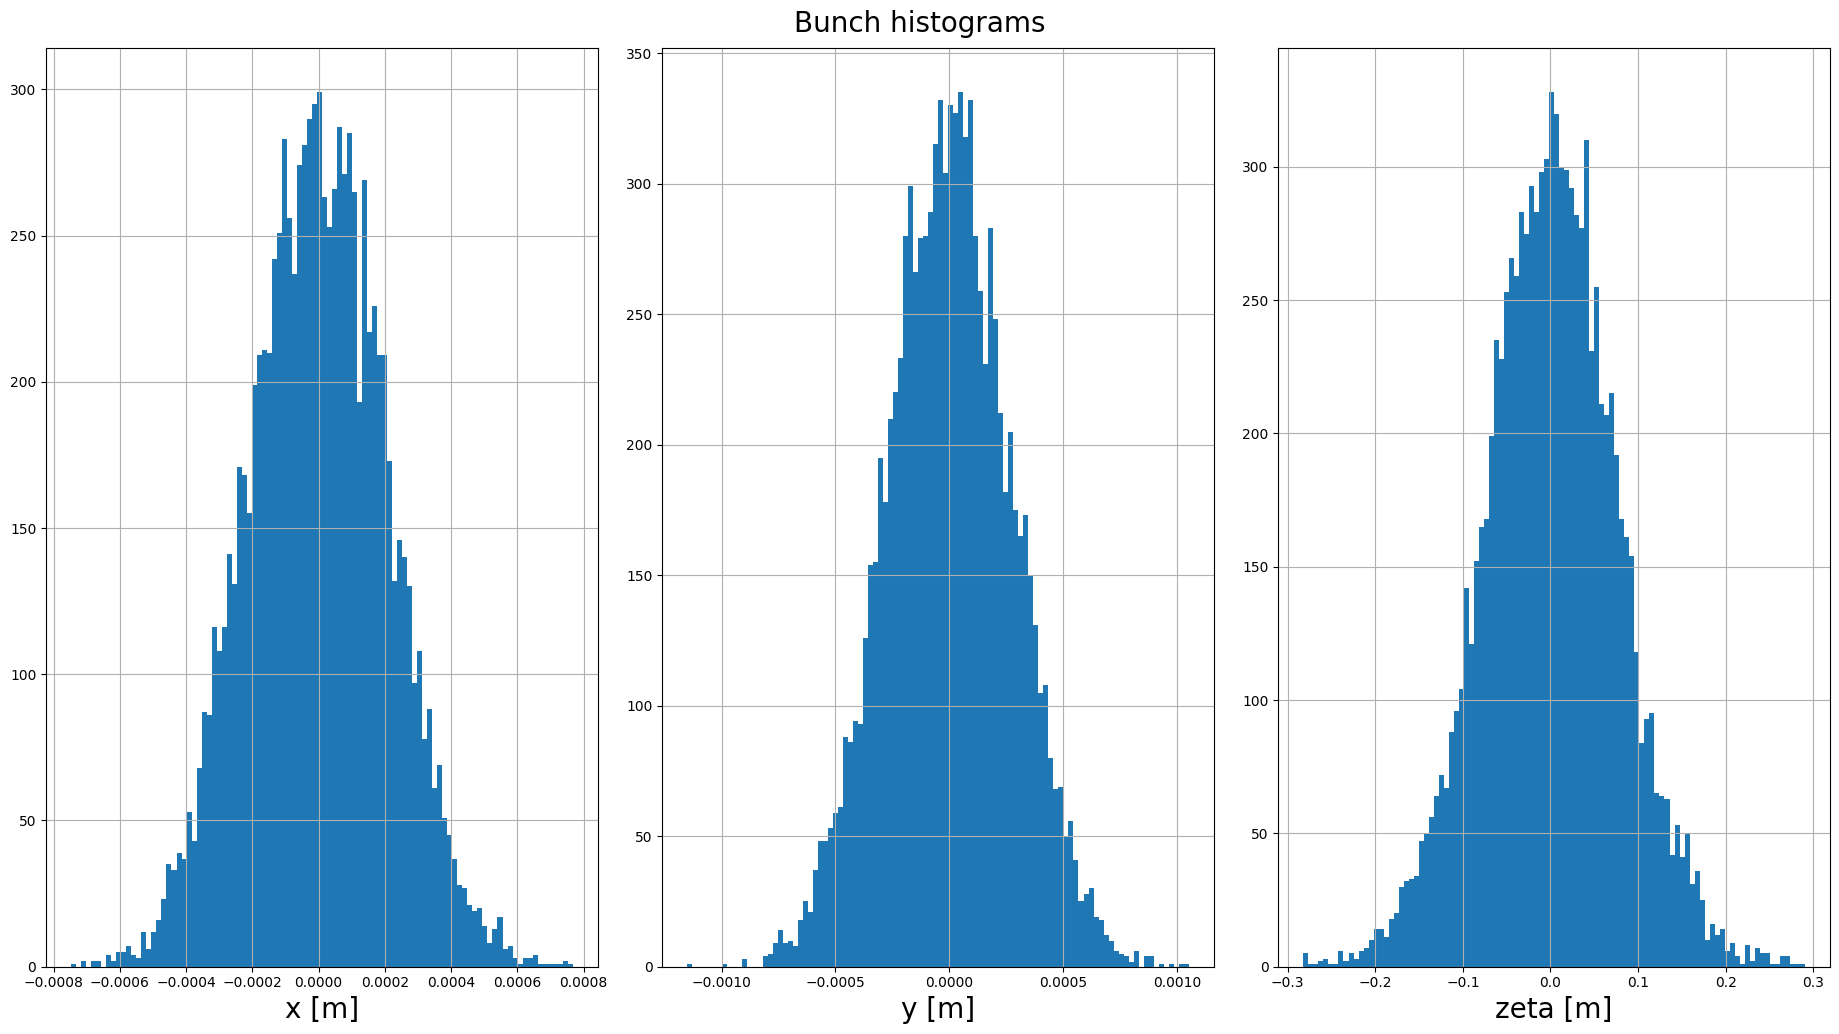

In [10]:
#We can plot the histograms of the particles
fig, ax = plt.subplots(1,3)
fig.set_size_inches(18.5, 10.5)
fontsize = 20
fig.suptitle('Bunch histograms', fontsize = fontsize)
ax[0].hist(starting_x, bins = 100)
ax[0].set_xlabel('x [m]', fontsize = fontsize)
ax[0].grid()
ax[1].hist(starting_y, bins = 100)
ax[1].set_xlabel('y [m]', fontsize = fontsize)
ax[1].grid()
ax[2].hist(starting_zeta, bins = 100)
ax[2].set_xlabel('zeta [m]', fontsize = fontsize)
ax[2].grid()
plt.tight_layout()

In [11]:
# We can also track the bunch through the whole line
# Now we perform more turns
N_turns = 10
collider['lhcb1'].track(gaussian_bunch, num_turns = N_turns)

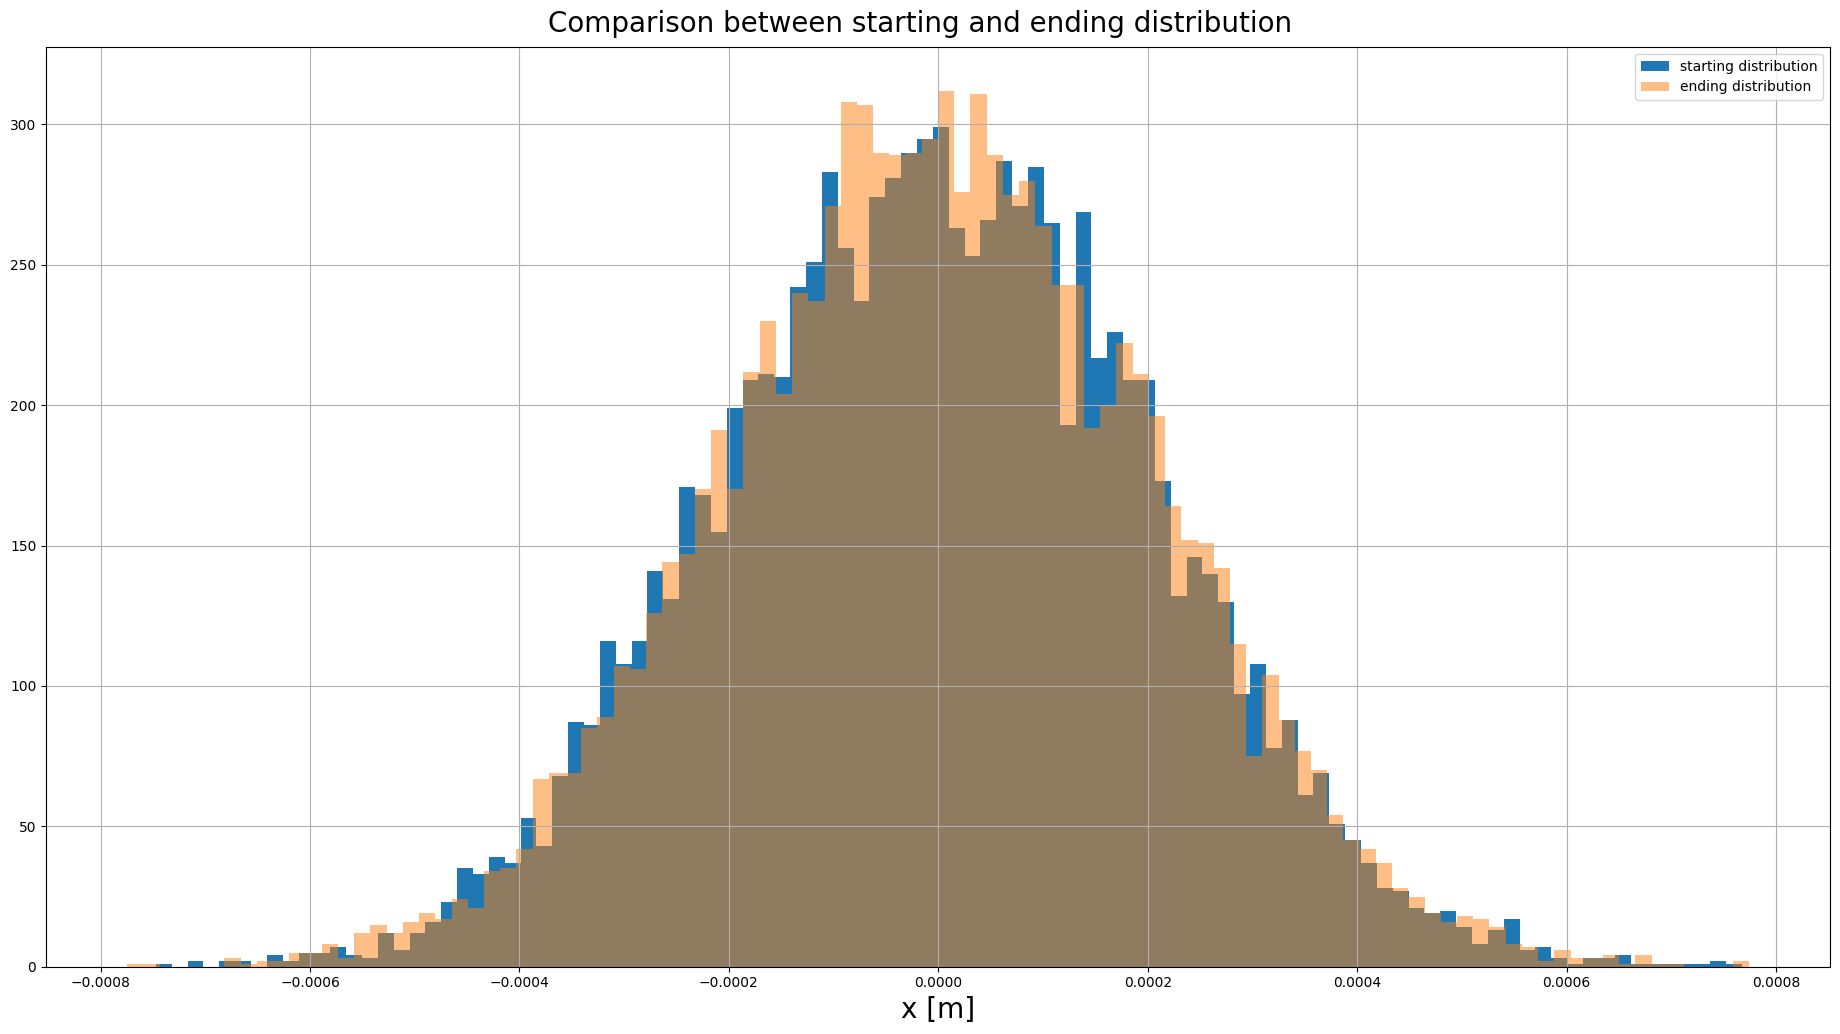

In [12]:
# We can compare the starting and ending distribution
ending_x = ctx.nparray_from_context_array(gaussian_bunch.x).copy()
fig, ax = plt.subplots(1,1)
fig.set_size_inches(18.5, 10.5)
fontsize = 20
fig.suptitle('Comparison between starting and ending distribution', fontsize = fontsize)
ax.hist(starting_x, bins = 100, label = 'starting distribution')
ax.hist(ending_x, bins = 100, label = 'ending distribution', alpha = 0.5)
ax.set_xlabel('x [m]', fontsize = fontsize)
ax.grid()
ax.legend()
plt.tight_layout()
# The distribution changed, as expected

In [13]:
# Sometimes we want to perform studies with frozen longitudinal coordinates
# Let's start with the twiss in 4d
# We can do it by specifying method='4d' in the twiss
# How can this be useful?
# For example we can study the tune shift with amplitude
# We want to explore various delta values
delta_values = np.linspace(-5e-3, 5e-3, 200)
# We create the tune lists
qx_values = delta_values * 0
qy_values = delta_values * 0
for i, delta in enumerate(delta_values):
    if(i%50==0):
        print(f'Iteration {i} of {len(delta_values)}')
    # We perform the twiss for each delta and save the tunes
    tw4d = collider['lhcb1'].twiss(method='4d', delta0=delta)
    qx_values[i] = tw4d.qx
    qy_values[i] = tw4d.qy

Iteration 0 of 200
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Warning! Need second attempt on closed orbit search
Warning! Need second attempt on closed orbit search
Iteration 50 of 200
Iteration 100 of 200
Iteration 150 of 200
Warning! Need second attempt on closed orbit search


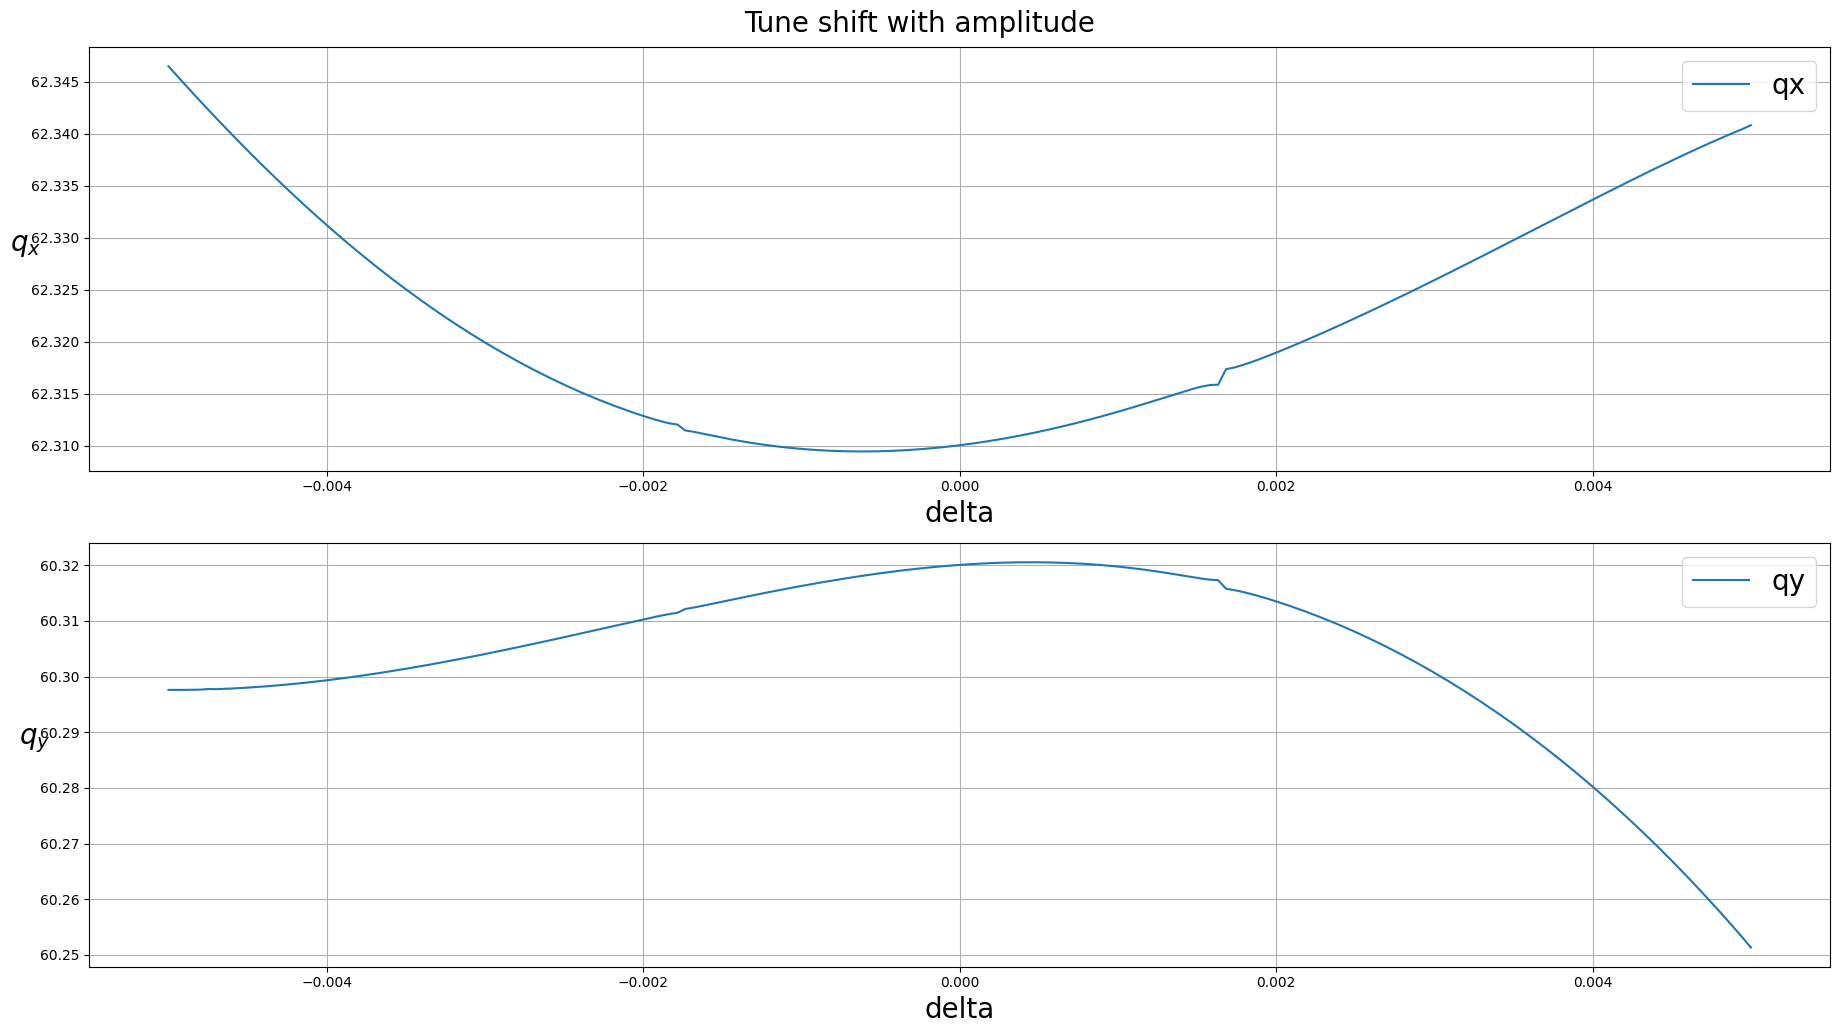

In [14]:
# We can plot the tune shift with amplitude
fig, ax = plt.subplots(2,1)
fig.set_size_inches(18.5, 10.5)
fontsize = 20
fig.suptitle('Tune shift with amplitude', fontsize = fontsize)
ax[0].plot(delta_values, qx_values, label = 'qx')
ax[0].set_xlabel('delta', fontsize = fontsize)
ax[0].set_ylabel(r'$q_{x}$', fontsize = fontsize, rotation = 0)
ax[0].grid()
ax[0].legend(fontsize = fontsize)
ax[1].plot(delta_values, qy_values, label = 'qy')
ax[1].set_xlabel('delta', fontsize = fontsize)
ax[1].set_ylabel(r'$q_{y}$', fontsize = fontsize, rotation = 0)
ax[1].grid()
ax[1].legend(fontsize = fontsize)
plt.tight_layout()

In [15]:
# We can also freeze the longitudinal coordinates in the tracking
# We create a particle with longitudinal coordinates different from 0

my_particle = xp.Particles(
                    mass0=xp.PROTON_MASS_EV, q0=1, energy0=7000e9, zeta = 0.08, delta = 1e-1)
print('---------Particle before tracking------')
print('zeta = ', ctx.nparray_from_context_array(my_particle.zeta), 
      'delta = ', ctx.nparray_from_context_array(my_particle.delta))
with xt.freeze_longitudinal(collider['lhcb1']):
     collider['lhcb1'].track(my_particle, num_turns = 10)
print('---------Particle after tracking------')
print('zeta = ', ctx.nparray_from_context_array(my_particle.zeta),
      'delta = ', ctx.nparray_from_context_array(my_particle.delta))
my_particle = xp.Particles(
                    mass0=xp.PROTON_MASS_EV, q0=1, energy0=7000e9, zeta = 0.08, delta = 1e-1)
collider['lhcb1'].track(my_particle, num_turns = 10)
print('---------Particle after tracking without frozen longitudinal coordinates------')
print('zeta = ', ctx.nparray_from_context_array(my_particle.zeta),
      'delta = ', ctx.nparray_from_context_array(my_particle.delta))

---------Particle before tracking------
zeta =  [0.08] delta =  [0.1]
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
---------Particle after tracking------
zeta =  [0.08] delta =  [0.1]
---------Particle after tracking without frozen longitudinal coordinates------
zeta =  [-0.07193476] delta =  [0.09999925]
